In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.signal import ricker
import seaborn as sns
sns.set(context='paper', style='whitegrid', )
from post_processing.la_habra import *

mpl.style.use('seaborn')
%load_ext autoreload
%autoreload 2

In [228]:
import collections
AWP = collections.namedtuple('AWP', a.keys())
aa = AWP(**a)
d = {'NX': 1, 'Y':{'b':10}}
bb = AttrDict(d)
bb.c['e']=1
print(bb)
print(aa._fields)

AttributeError: c

In [187]:
a = foo('homo_2layer_point_flat/param.sh')
print(type(a['X']), a['X'])
print(a)

<class 'int'> 300
{'X': 300, 'DT': 0.003, 'NN': 1}


In [2]:
def func_ricker(t, fc, t0):
    F = (np.pi * fc * (t - t0)) ** 2 
    return (1 - 2 * F) * np.exp(-F)

In [3]:
def write_mesh(nx, ny, nz, vp, vs, rho, fmesh):
    _vp = vp * np.ones((ny, nx), dtype='float32')
    _vs = vs * np.ones((ny, nx), dtype='float32')
    _rho = rho * np.ones((ny, nx), dtype='float32')
    dummy = np.zeros((ny, nx), dtype='float32')
    with open(fmesh, 'wb') as fid:
        for _ in range(nz):
            mesh = np.dstack((_vp, _vs, _rho))#, dummy, dummy))
            mesh.tofile(fid)

In [4]:
def read_slice(it, bgx, skpx, endx, bgy, skpy, endy, bgz, skpz, endz,
               ix=0, iy=0, iz=0, model="", case="", block=0, comp="X"):
    '''Read wave field snapshot
    Input:
        it: time step to read
        mx, my: Surface 2D dimensions
        model: the name of the model
        case: different cases of a model, if exists
    '''
    tmax, dt, tskip, wstep, _ = read_params(model)
    ix, iy, iz = ix - 1, iy - 1, iz - 1  # convert to 0-indexed
    nt = int(tmax / dt)
    rx = np.arange(bgx, endx + 1, skpx)
    ry = np.arange(bgy, endy + 1, skpy)
    rz = np.arange(bgz, endz + 1, skpz)
    mx, my, mz = len(rx), len(ry), len(rz)
    print(f"\nShape of velocity output: ({mx}, {my}, {mz})")
    model = Path(model, "output_sfc" if not case else f"output_sfc_{case}")
    print(model)
    
    fnum = int(np.ceil((it + 1) / wstep) * wstep * tskip)
    print(f'\r{it} / {nt}, t = {dt * it}s, f_suffix={fnum}', end="\r", flush=True)
    v = np.fromfile(f'{model}/S{comp}_{block}_{fnum:07d}', dtype='float32',
                   count=mz * my * mx, offset=it * mx * my * mz * 4).reshape(mz, my, mx)
    idx = np.where(np.isnan(v))
    if np.isnan(v).any():
        print(f"\n{len(idx[0])} NANs founded\n")
                   
    if iy > 0:
        v = v[:, iy, :]
        print(f'\nThe y_index is: {ry[iy]} / {endy}, Vmax = {np.max(v)}')
    elif ix >= 0:
        v = v[:, :, ix]
        print(f'\nThe x_index is: {rx[ix]} / {endx}, Vmax = {np.max(v)}')
    elif iz >= 0:
        v = v[iz, :, :]
        print(f'\nThe z_index is: {rz[iz]} / {endz}, Vmax = {np.max(v)}')
    return v.copy(), idx, dt

In [21]:
def plot_slice_y(it, model="", case="", iy=101, iy2=51, sx=450, sz=100, comp='Z', norm='log'):
    v, idx, dt = read_slice(it, bgx, skpx, endx, bgy, skpy, endy, bgz, skpz, endz,
                       iy=iy, block=0, model=model, case=case, comp=comp)
    v2, idx, dt = read_slice(it, bgx2, skpx2, endx2, bgy2, skpy2, endy2, bgz2, skpz2, endz2,
                            iy=iy2, block=1, model=model, case=case, comp=comp)
    print(it, dt, it*dt)
    vmin, vmax = min(np.min(v), np.min(v2)), max(np.max(v), np.max(v2))
    if norm == 'log':
        norm = colors.SymLogNorm(linthresh=1e-4)
    else:
        norm = None
    fig, ax = plt.subplots(dpi=200)
    im = ax.pcolormesh(np.arange(bgx, endx + 1, skpx) * dh,
                       np.arange(bgz, endz + 1, skpz) * dh,
                       v, vmin=vmin, vmax=vmax, norm=norm, cmap='bwr')
    im = ax.pcolormesh(np.arange(bgx2, endx2 + 1, skpx2) * dh2,
                        nz * dh + np.arange(bgz2, endz2 + 1, skpz2) * dh2,
                        v2, vmin=vmin, vmax=vmax, norm=norm, cmap='bwr')
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.scatter(sx * dh, sz * dh, 150, color='g', marker='*')
    ax.axvline(nx // 3 * dh, linestyle=':', linewidth=1.2, color='c')
    ax.axvline(nx * 2 // 3 * dh, linestyle=':', linewidth=1.2, color='c')
    ax.set(xlabel='X (m)', ylabel='Z (m)', title=f'T = {it * dt:.1f}s')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(f'V{comp} (m/s)')

In [22]:
def plot_slice_x(it, model="", case="", ix=113, ix2=75, sy=300, sz=100, comp='Y', norm='log'):
    v, idx, dt = read_slice(it, bgx, skpx, endx, bgy, skpy, endy, bgz, skpz, endz,
                           ix=ix, block=0, model=model, case=case, comp=comp)
    v2, idx, dt = read_slice(it, bgx2, skpx2, endx2, bgy2, skpy2, endy2, bgz2, skpz2, endz2,
                            ix=ix2, block=1, model=model, case=case, comp=comp)
    vmin, vmax = min(np.min(v), np.min(v2)), max(np.max(v), np.max(v2))
    if norm == 'log':
        norm = colors.SymLogNorm(linthresh=1e-4)
    else:
        norm = None
    fig, ax = plt.subplots(dpi=200)
    im = ax.pcolormesh(np.arange(bgy, endy + 1, skpy) * dh,
                       np.arange(bgz, endz + 1, skpz) * dh,
                       v, vmin=vmin, vmax=vmax, norm=norm, cmap='bwr')
    im = ax.pcolormesh(np.arange(bgy2, endy2 + 1, skpy2) * dh2,
                        nz * dh + np.arange(bgz2, endz2 + 1, skpz2) * dh2,
                        v2, vmin=vmin, vmax=vmax, norm=norm, cmap='bwr')
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.scatter(sy * dh, sz * dh, 150, color='g', marker='*')
    ax.axvline(ny // 2 * dh, linestyle=':', linewidth=1.2, color='c')
    ax.set(xlabel='Y (m)', ylabel='Z (m)', title=f'T = {it * dt:.1f}s')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(f'V{comp} (m/s)')

In [62]:
def plot_slice_z(it, model="", case="", iz=34, iz2=1, sx=450, sy=300, comp='X', norm='log'):
    v, idx, dt = read_slice(it, bgx, skpx, endx, bgy, skpy, endy, bgz, skpz, endz,
                           iz=iz, block=0, model=model, case=case, comp=comp)
    v2, idx, dt = read_slice(it, bgx2, skpx2, endx2, bgy2, skpy2, endy2, bgz2, skpz2, endz2,
                            iz=iz2, block=1, model=model, case=case, comp=comp)
    vmin, vmax = min(np.min(v), np.min(v2)), max(np.max(v), np.max(v2))
    if norm == 'log':
        norm = colors.SymLogNorm(linthresh=1e-4)
    else:
        norm = None
    fig, ax = plt.subplots(1, 2, dpi=200)
    fig.subplots_adjust(wspace=0.4)
    im = ax[0].pcolormesh(np.arange(bgx, endx + 1, skpx) * dh,
                         np.arange(bgy, endy + 1, skpy) * dh,
                         v, vmin=vmin, vmax=vmax, norm=norm, cmap='bwr')
    vmin, vmax = np.min(v2) or np.min(v), np.max(v2) or np.max(v)
    im2 = ax[1].pcolormesh(np.arange(bgx2, endx2 + 1, skpx2) * dh2,
                          np.arange(bgy2, endy2 + 1, skpy2) * dh2,
                          v2, vmin=vmin, vmax=vmax, norm=norm, cmap='bwr')
    for ix in ax:
        ix.set_aspect('equal')
        ix.invert_yaxis()
        ix.scatter(sx * dh, sy * dh, 150, color='g', marker='*')
        ix.axvline(nx // 3 * dh, linestyle=':', linewidth=1.2, color='c')
        ix.axvline(nx * 2 // 3 * dh, linestyle=':', linewidth=1.2, color='c')
        ix.axhline(ny // 2 * dh, linestyle=':', linewidth=1.2, color='c')
        ix.set(xlabel='X (m)', ylabel='Y (m)', title=f'T = {it * dt:.1f}s')
    cbar = plt.colorbar(im, ax=ax[0], orientation='horizontal')
    cbar.set_label(f'V{comp} (m/s)')
    cbar = plt.colorbar(im2, ax=ax[1], orientation='horizontal')
    cbar.set_label(f'V{comp} (m/s)')

## Model set up

### Mesh

In [107]:
nx, ny, nz, mz = 900, 600, 300, 200
vp, vs, rho = 4000, 2500, 2500
dh, dh2 = 30, 90
dt, nt = 0.003, 1000
t = np.arange(nt) * dt
print(f'dt < {dh / vp / 2} ')
assert dt < dh / vp / 2

bgx, skpx, endx = 1, 4, 900
bgy, skpy, endy = 1, 3, 600
bgz, skpz, endz = 1, 3, 300
bgx2, skpx2, endx2 = 1, 2, 300
bgy2, skpy2, endy2 = 1, 2, 200
bgz2, skpz2, endz2 = 1, 2, 200

# write_mesh(nx, ny, nz, vp, vs, rho, 'homo_2layer_point/mesh_0')
# write_mesh(nx // 3, ny // 3, mz, vp, vs, rho, 'homo_2layer_point/mesh_1')


## Topo
pad = 8
height = 50
header = np.array([nx, ny, pad], dtype='int32')
topo = height * np.ones((nx + 2 * pad, ny + 2 * pad), dtype='float32')
with open('homo_2layer_point_flat/topography.bin', 'wb') as fid:
    header.tofile(fid)
    topo.astype('float32').tofile(fid)
    
# x = np.arange(endx + 2 * pad)
# y = np.arange(endy + 2 * pad)[:,np.newaxis]
# sigma = 300
# topo = height * np.exp(- ((x - pad - nx // 2) ** 2 + (y - pad - ny // 2) ** 2) / sigma ** 2)
# with open('homo_2layer_gauss_y/topography.bin', 'wb') as fid:
#     header.tofile(fid)
#     topo.astype('float32').tofile(fid)
# plt.imshow(topo)
# plt.colorbar()

dt < 0.00375 


### Source

In [37]:
M0 = 1e15
fc, t0 = 1, 1.5
assert vs / dh2 / fc > 7

src = np.zeros((nt, 6))
src_ricker = func_ricker(t, fc, t0)
for i in range(3):
    src[:, i] = M0 * src_ricker

with open('homo_2layer_point_flat/source_0', 'wb') as fid:
    idx = np.array([nx // 2, ny // 2, mz // 2], dtype='int32')
    fid.write(idx)
    fid.write(src.astype('float32'))
    
with open('homo_2layer_point_flat/source_1', 'wb') as fid:
    idx = np.array([nx // 6, ny // 6, mz // 2], dtype='int32')
    fid.write(idx)
    fid.write(src.astype('float32'))
    

In [19]:
M0 = 1e15
fc, t0 = 1, 1.5
assert vs / dh2 / fc > 7

src = np.zeros((nt, 6))
src_ricker = func_ricker(t, fc, t0)
for i in range(3):
    src[:, i] = M0 * src_ricker

with open('homo_2layer_toy/source_0', 'wb') as fid:
    idx = np.array([nx // 2 - 100, ny // 2 - 100, mz // 2], dtype='int32')
    fid.write(idx)
    fid.write(src.astype('float32'))
    
with open('homo_2layer_toy/source_1', 'wb') as fid:
    idx = np.array([nx // 6, ny // 6, mz // 2], dtype='int32')
    fid.write(idx)
    fid.write(src.astype('float32'))

## Snapshot comparison

### AWP-TOPO, topo on

#### X-Z plane


Shape of velocity output: (225, 200, 100)
homo_2layer_point_flat/output_sfc
110 / 300, t = 3.3s, f_suffix=3000
The y_index is: 301 / 600, Vmax = 0.11992724239826202

Shape of velocity output: (150, 100, 100)
homo_2layer_point_flat/output_sfc
110 / 300, t = 3.3s, f_suffix=3000
The y_index is: 101 / 200, Vmax = 0.02278928831219673
110 0.03 3.3


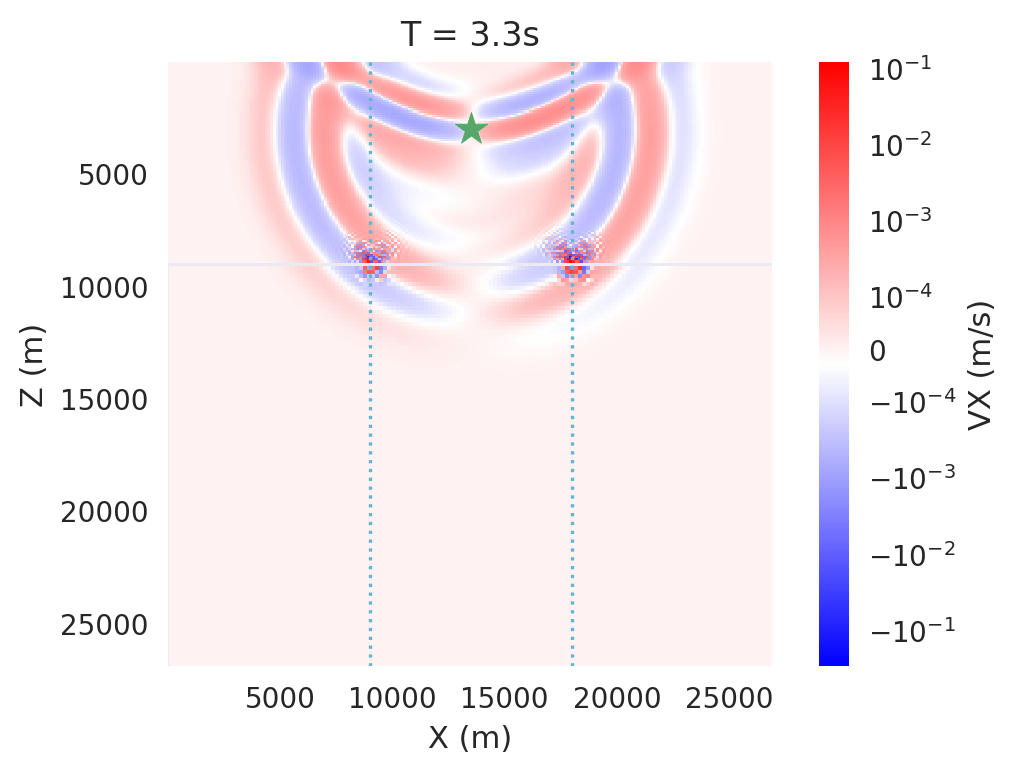

In [101]:
plot_slice_y(110, 'homo_2layer_point_flat', comp='X')

#### Y-Z plane


Shape of velocity output: (225, 200, 100)
homo_2layer_point_flat/output_sfc
140 / 300, t = 4.2s, f_suffix=3000
The x_index is: 449 / 900, Vmax = 0.000276996404863894

Shape of velocity output: (150, 100, 100)
homo_2layer_point_flat/output_sfc
140 / 300, t = 4.2s, f_suffix=3000
The x_index is: 149 / 300, Vmax = 0.00027600655448623


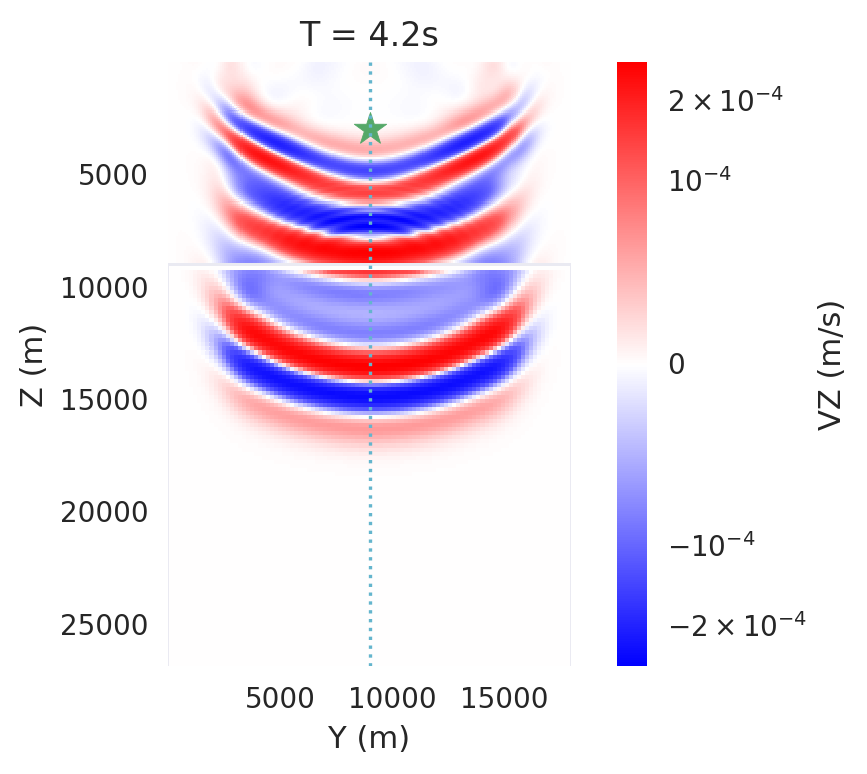

In [149]:
plot_slice_x(140, 'homo_2layer_point_flat', comp='Z')

#### X-Y plane


Shape of velocity output: (225, 200, 100)
homo_2layer_point_flat/output_sfc
110 / 300, t = 3.3s, f_suffix=3000
The z_index is: 100 / 300, Vmax = 0.0005283780628815293

Shape of velocity output: (150, 100, 100)
homo_2layer_point_flat/output_sfc
110 / 300, t = 3.3s, f_suffix=3000
The z_index is: 1 / 200, Vmax = 0.008013749495148659


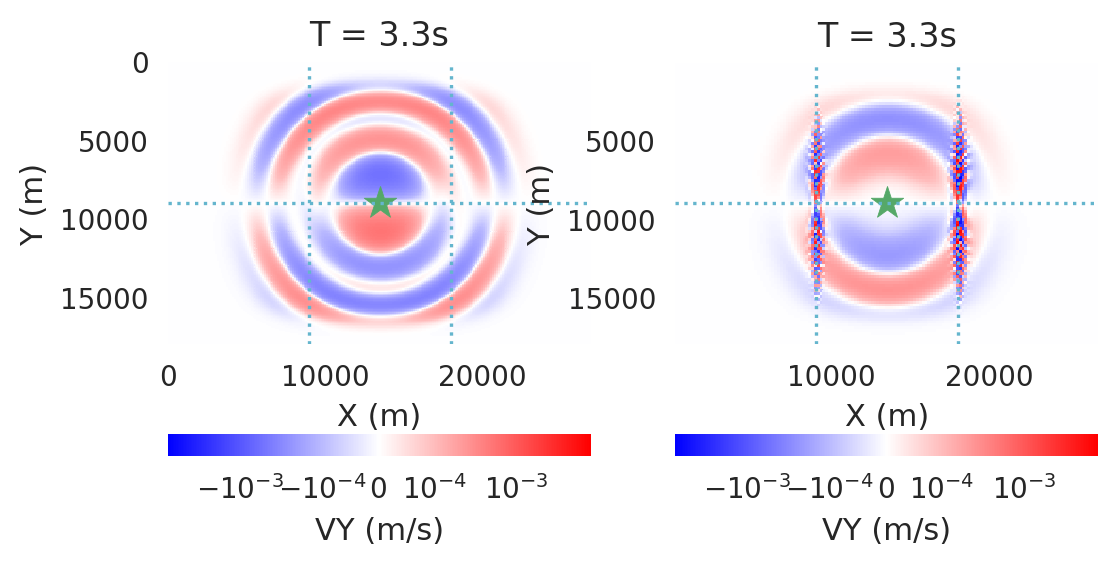

In [44]:
plot_slice_z(110, iz=34, iz2=1, model='homo_2layer_point_flat', comp='Y', norm='log')

### AWP-TOPO, topo off

#### X-Z plane


Shape of velocity output: (225, 200, 100)
homo_2layer_point_flat/output_sfc_notp
100 / 300, t = 3.0s, f_suffix=3000
The y_index is: 301 / 600, Vmax = 0.0005255177966319025

Shape of velocity output: (150, 100, 100)
homo_2layer_point_flat/output_sfc_notp
100 / 300, t = 3.0s, f_suffix=3000
The y_index is: 101 / 200, Vmax = 0.00013576936908066273
100 0.03 3.0


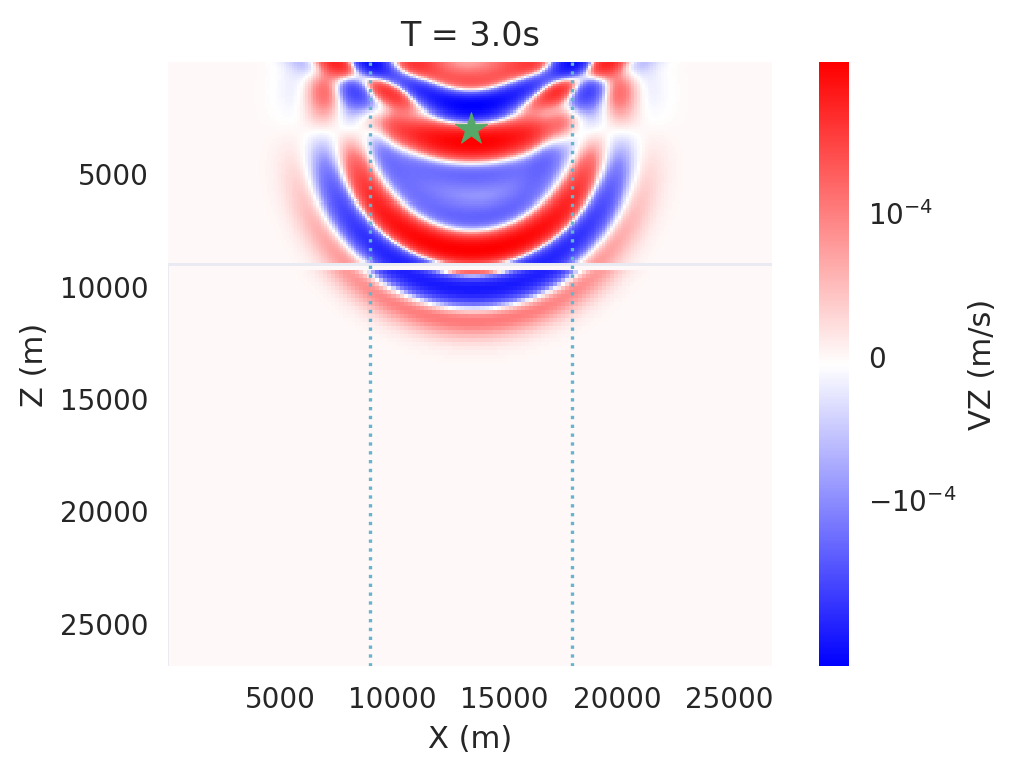

In [104]:
plot_slice_y(100, 'homo_2layer_point_flat', case='notp')

#### Y-Z plane


Shape of velocity output: (225, 200, 100)
homo_2layer_point_flat/output_sfc_notp
100 / 300, t = 3.0s, f_suffix=3000
The x_index is: 449 / 900, Vmax = 0.0005255721043795347

Shape of velocity output: (150, 100, 100)
homo_2layer_point_flat/output_sfc_notp
100 / 300, t = 3.0s, f_suffix=3000
The x_index is: 149 / 300, Vmax = 0.0001346647331956774


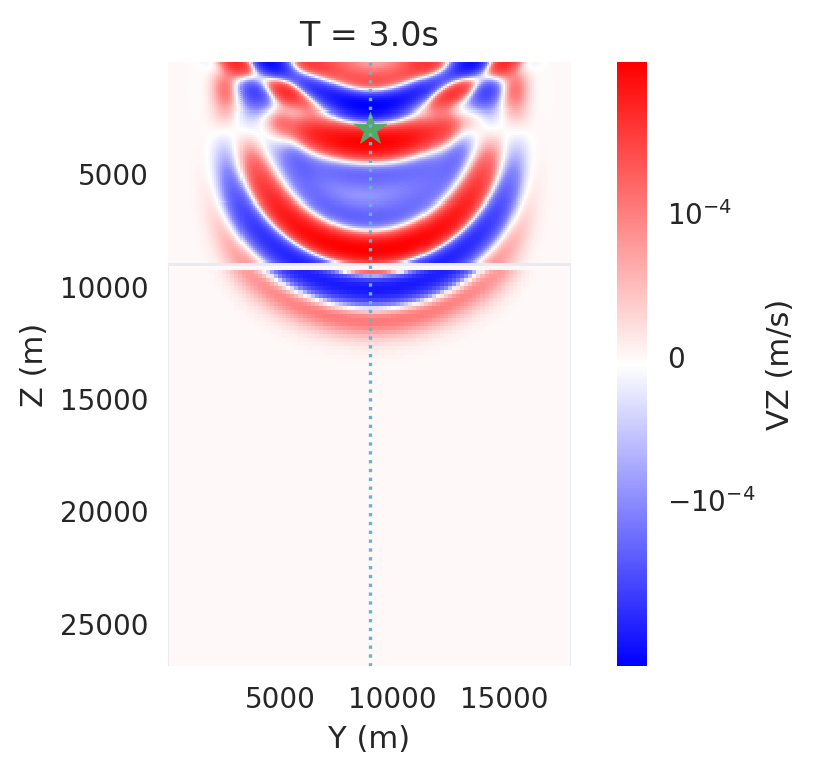

In [148]:
plot_slice_x(100, 'homo_2layer_point_flat', case='notp', comp='Z')

#### X-Y plane


Shape of velocity output: (225, 200, 100)
homo_2layer_point_flat/output_sfc_notp
70 / 300, t = 2.1s, f_suffix=3000
The z_index is: 100 / 300, Vmax = 0.07243037968873978

Shape of velocity output: (150, 100, 100)
homo_2layer_point_flat/output_sfc_notp
70 / 300, t = 2.1s, f_suffix=3000
The z_index is: 1 / 200, Vmax = 2.5386298148077913e-06


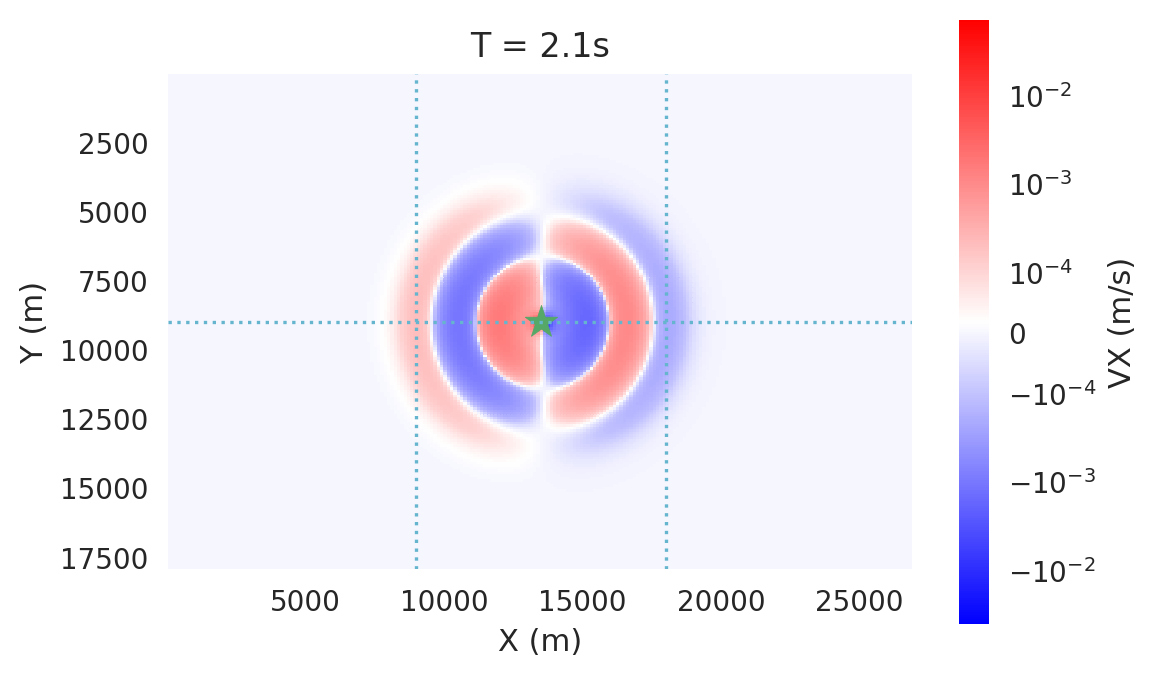

In [85]:
plot_slice_z(70, 'homo_2layer_point_flat', case='notp')

### AWP-DM

#### X-Z plane


Shape of velocity output: (225, 200, 100)
homo_2layer_point/output_sfc_old
100 / 300, t = 3.0s, f_suffix=3000
The y_index is: 301 / 600, Vmax = 0.0005269591929391026

Shape of velocity output: (150, 100, 100)
homo_2layer_point/output_sfc_old
100 / 300, t = 3.0s, f_suffix=3000
The y_index is: 101 / 200, Vmax = 0.0001382662885589525
100 0.03 3.0


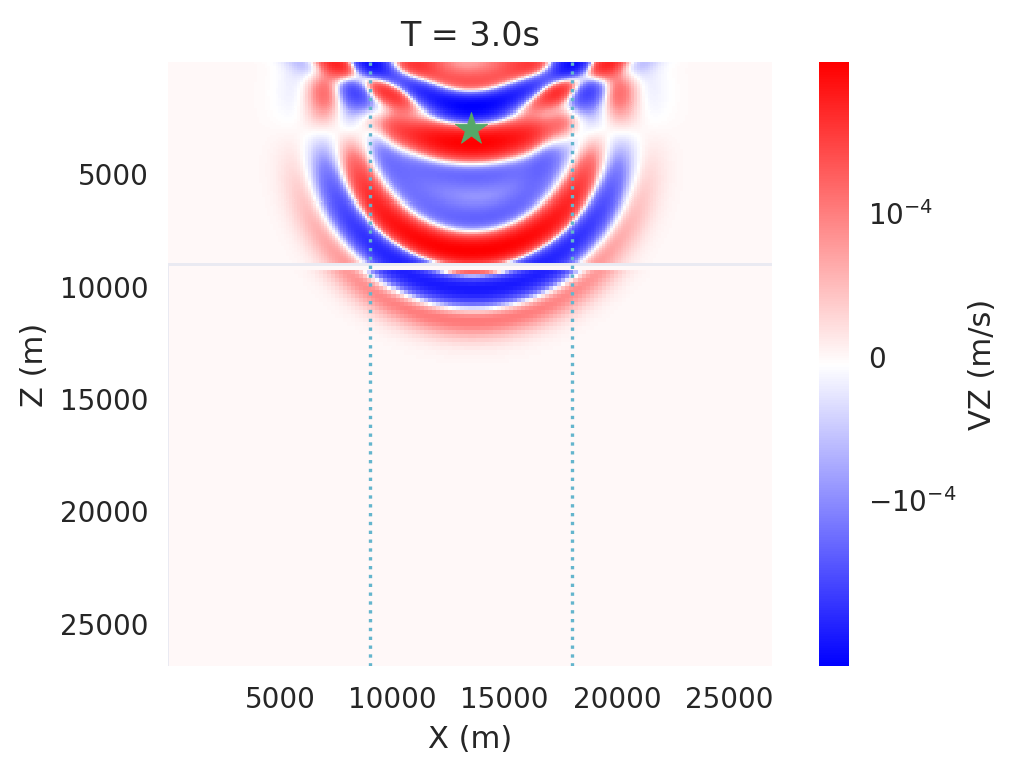

In [121]:
plot_slice_y(100, 'homo_2layer_point', case='old')


Shape of velocity output: (225, 200, 100)
homo_2layer_point/output_sfc
100 / 300, t = 3.0s, f_suffix=3000
The y_index is: 301 / 600, Vmax = 0.0005269591929391026

Shape of velocity output: (150, 100, 100)
homo_2layer_point/output_sfc
100 / 300, t = 3.0s, f_suffix=3000
The y_index is: 101 / 200, Vmax = 0.0001382662885589525
100 0.03 3.0


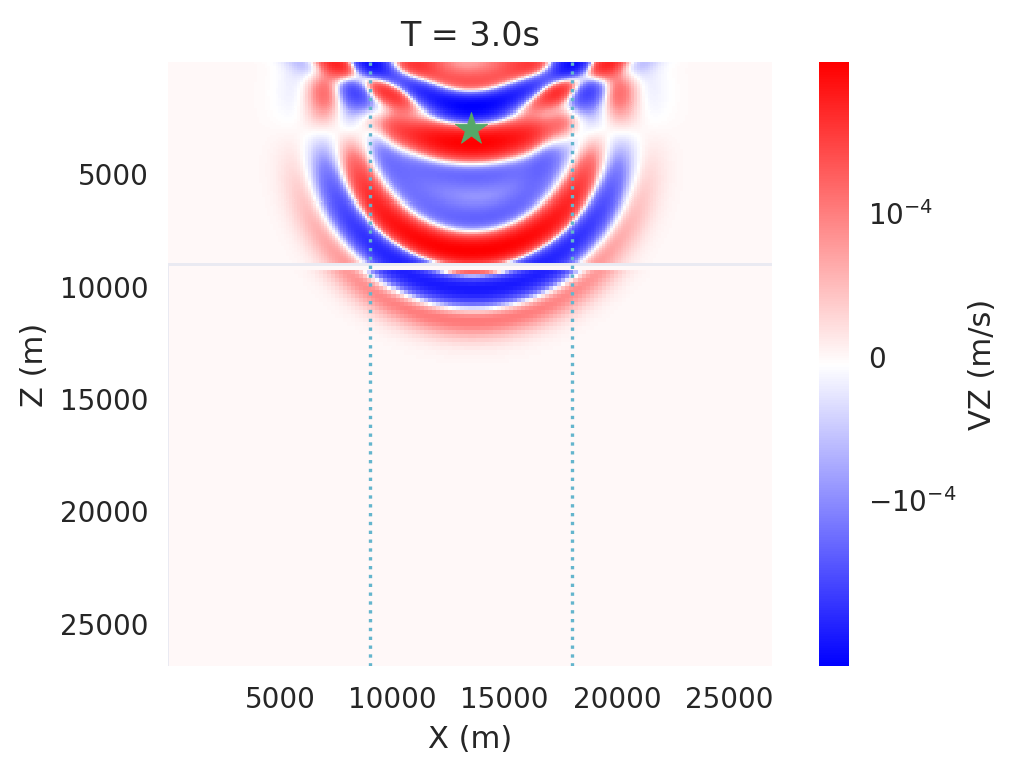

In [139]:
plot_slice_y(100, 'homo_2layer_point')


Shape of velocity output: (225, 200, 100)
homo_2layer_toy/output_sfc
140 / 300, t = 4.2s, f_suffix=3000
The y_index is: 301 / 600, Vmax = 0.0003963245253544301

Shape of velocity output: (150, 100, 100)
homo_2layer_toy/output_sfc
140 / 300, t = 4.2s, f_suffix=3000
The y_index is: 101 / 200, Vmax = 0.0003956094733439386
140 0.03 4.2


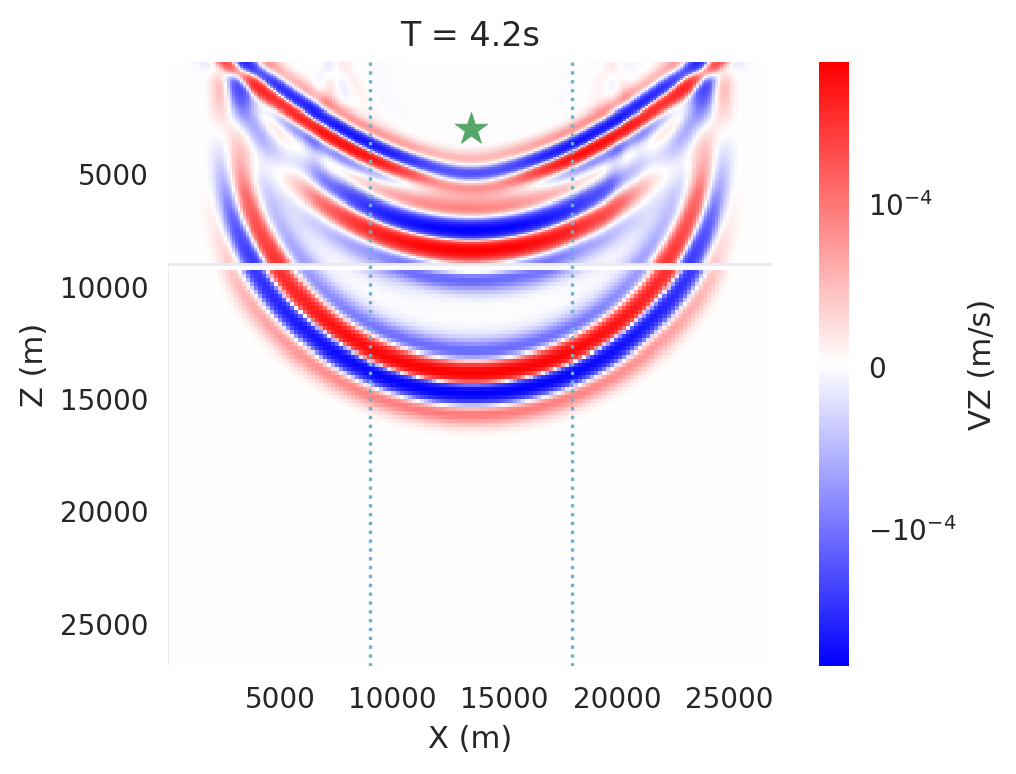

In [87]:
plot_slice_y(140, 'homo_2layer_toy')
#v = np.fromfile('homo_2layer_toy/output_sfc/SZ_1_0003000', dtype='float32').reshape(300, 100, 100, 150)
#v = v[130, :, :, :]
#print(v.max())

#### Y-Z plane


Shape of velocity output: (225, 200, 100)
homo_2layer_point/output_sfc
100 / 300, t = 3.0s, f_suffix=3000
The x_index is: 449 / 900, Vmax = 0.0005269591929391026

Shape of velocity output: (150, 100, 100)
homo_2layer_point/output_sfc
100 / 300, t = 3.0s, f_suffix=3000
The x_index is: 149 / 300, Vmax = 0.00013716075045522302


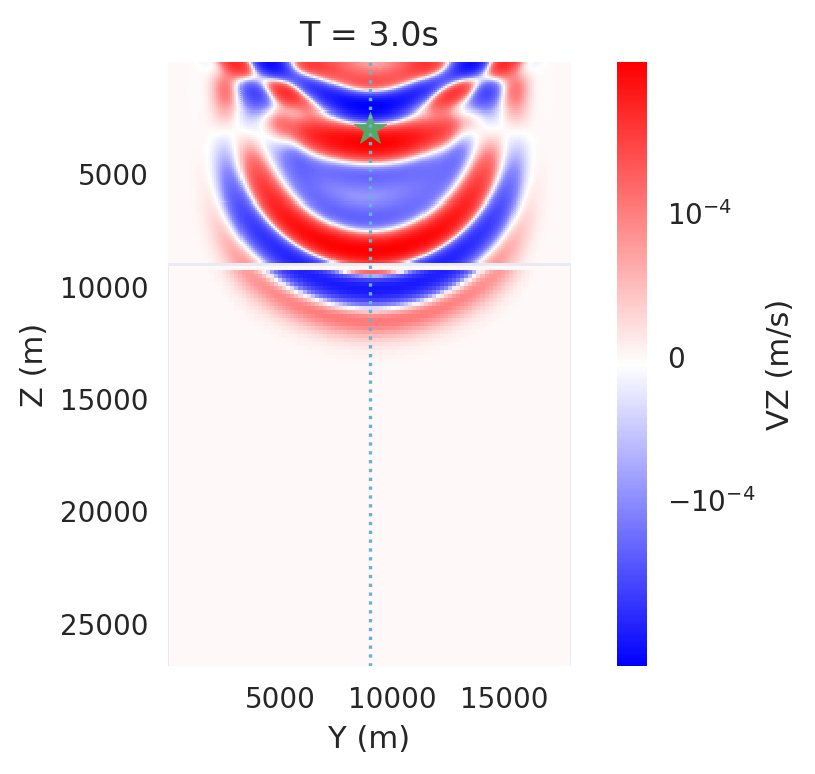

In [150]:
plot_slice_x(100, 'homo_2layer_point', comp='Z')

#### X-Y plane


Shape of velocity output: (225, 200, 100)
homo_2layer_point/output_sfc
50 / 300, t = 1.5s, f_suffix=3000
The z_index is: 100 / 300, Vmax = 0.024924015626311302

Shape of velocity output: (150, 100, 100)
homo_2layer_point/output_sfc
50 / 300, t = 1.5s, f_suffix=3000
The z_index is: 1 / 200, Vmax = 0.0


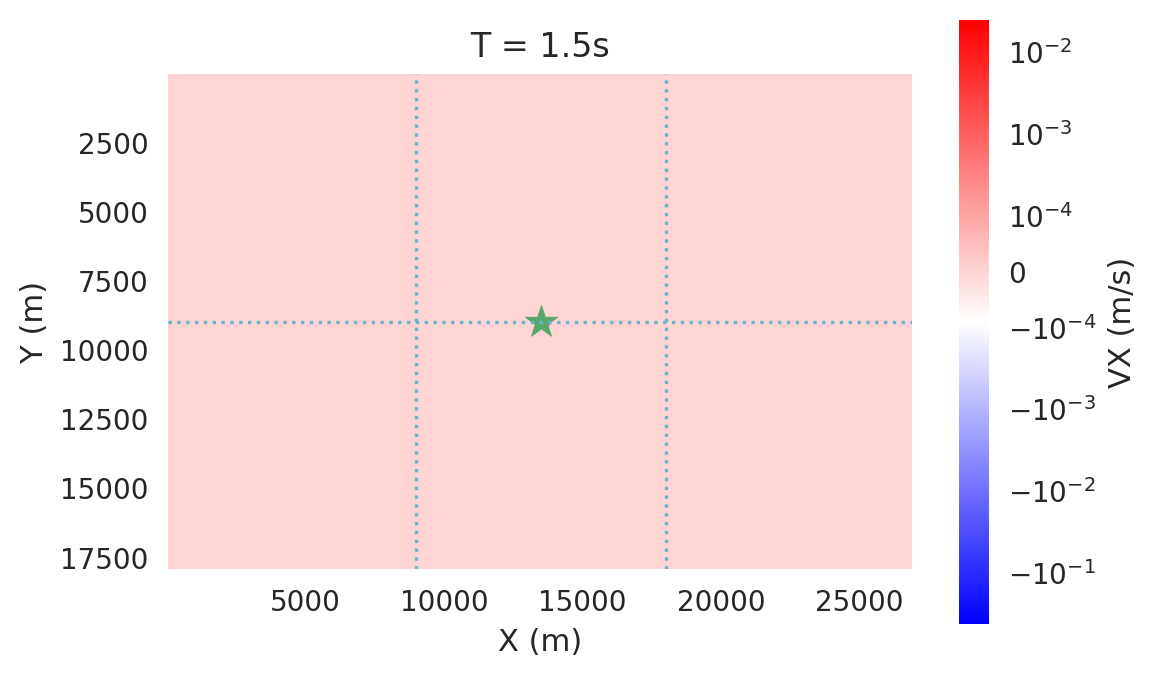

In [25]:
plot_slice_z(50, 'homo_2layer_point')

## Check

#### X-Z plane


Shape of velocity output: (225, 200, 100)
homo_2layer_toy/output_sfc
130 / 300, t = 3.9s, f_suffix=3000
The y_index is: 301 / 600, Vmax = 98860.2421875

Shape of velocity output: (150, 100, 100)
homo_2layer_toy/output_sfc
130 / 300, t = 3.9s, f_suffix=3000
The y_index is: 101 / 200, Vmax = 3441.01904296875
130 0.03 3.9


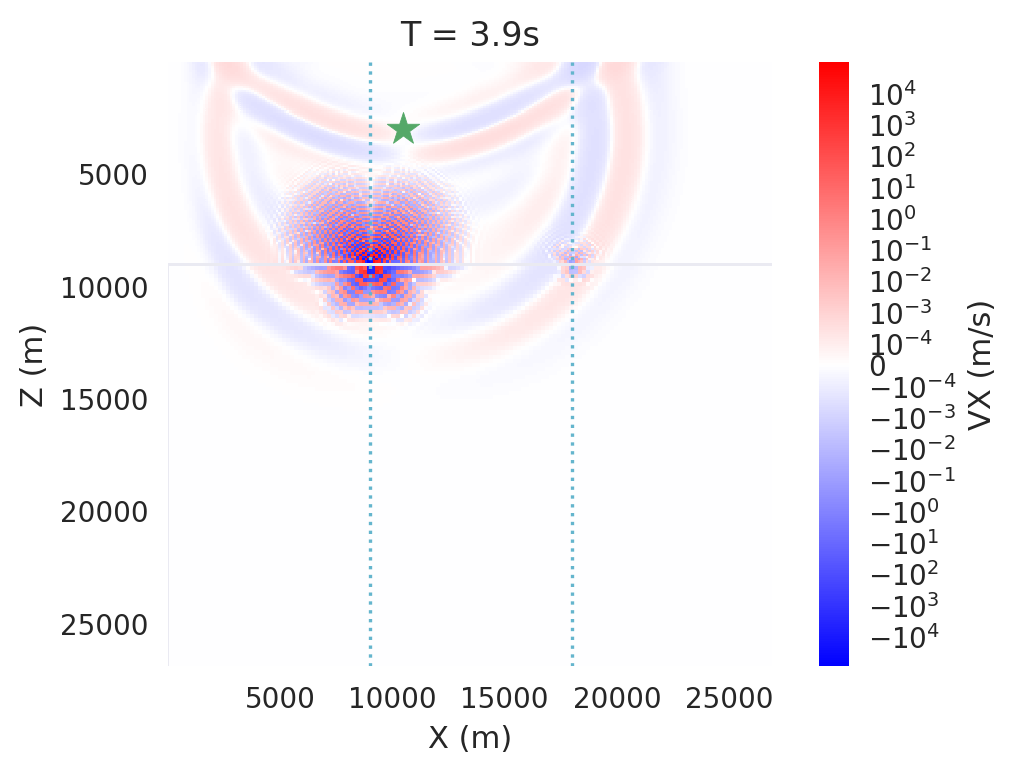

In [24]:
plot_slice_y(130, 'homo_2layer_toy', comp='X', sx=350)

#### Y-Z plane


Shape of velocity output: (225, 200, 100)
homo_2layer_toy/output_sfc
100 / 300, t = 3.0s, f_suffix=3000
The y_index is: 301 / 600, Vmax = 0.0012571739498525858

Shape of velocity output: (150, 100, 100)
homo_2layer_toy/output_sfc
100 / 300, t = 3.0s, f_suffix=3000
The y_index is: 101 / 200, Vmax = 0.00039936034590937197
100 0.03 3.0


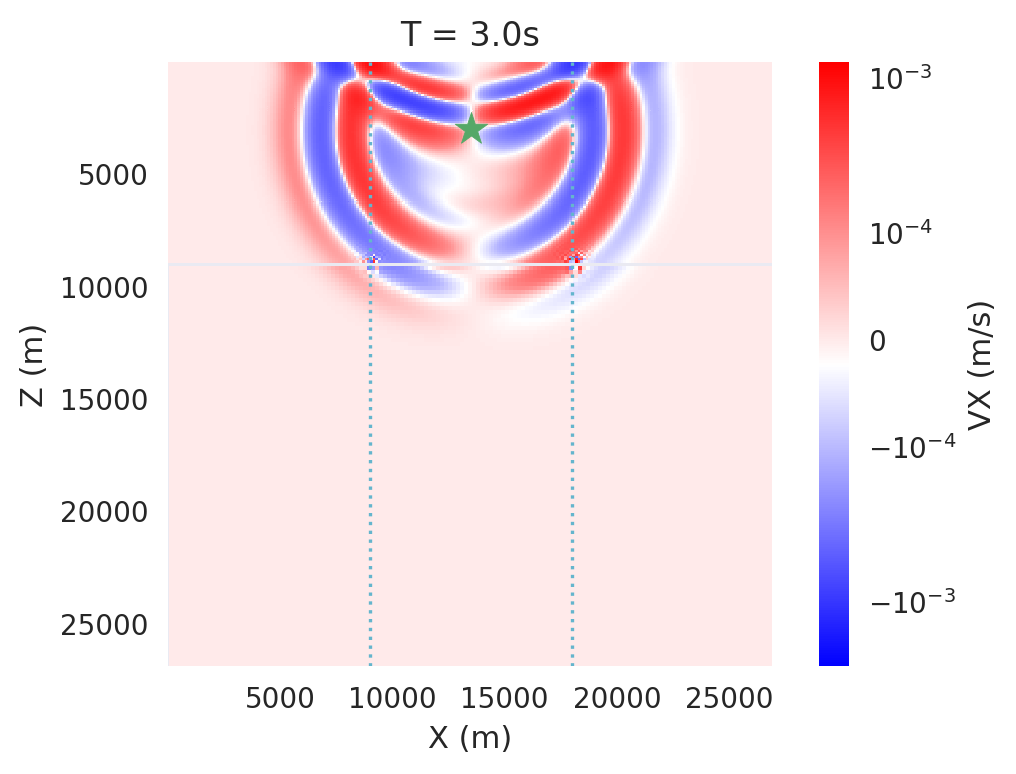

In [117]:
plot_slice_y(100, 'homo_2layer_toy', comp='X')


Shape of velocity output: (225, 200, 100)
homo_2layer_toy/output_sfc
130 / 300, t = 3.9s, f_suffix=3000
The z_index is: 100 / 300, Vmax = 0.00045247882371768355

Shape of velocity output: (150, 100, 100)
homo_2layer_toy/output_sfc
130 / 300, t = 3.9s, f_suffix=3000
The z_index is: 1 / 200, Vmax = 221.8315887451172


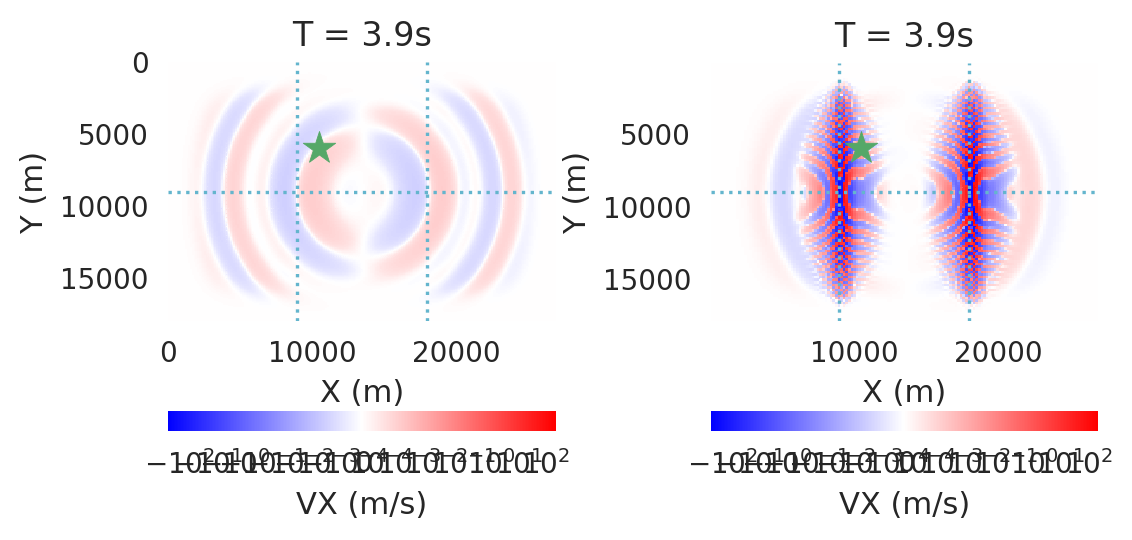

In [118]:
plot_slice_z(130, 'homo_2layer_toy', comp='X', sx=350, sy=200)


Shape of velocity output: (225, 200, 100)
homo_2layer_flat_y/output_sfc
280 / 300, t = 8.4s, f_suffix=3000
The z_index is: 100 / 300, Vmax = 0.00022867742518428713

Shape of velocity output: (150, 100, 100)
homo_2layer_flat_y/output_sfc
280 / 300, t = 8.4s, f_suffix=3000
The z_index is: 1 / 200, Vmax = 0.00029669597279280424


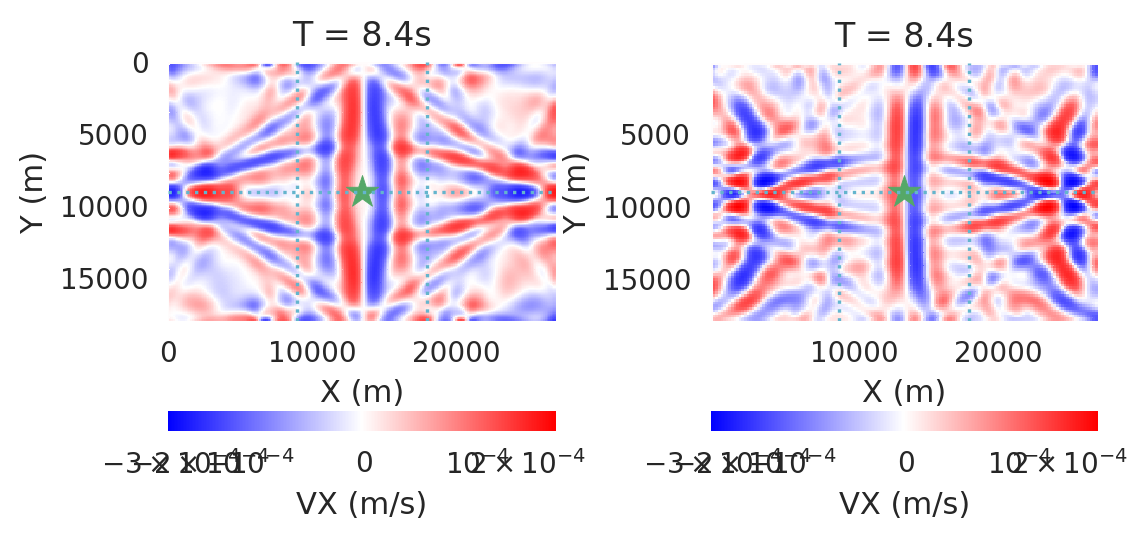

In [102]:
plot_slice_z(280, 'homo_2layer_flat_y', comp='X')


Shape of velocity output: (225, 200, 100)
homo_2layer_gauss_y/output_sfc
299 / 300, t = 8.969999999999999s, f_suffix=3000
The z_index is: 100 / 300, Vmax = 3.352135081513552e-06

Shape of velocity output: (150, 100, 100)
homo_2layer_gauss_y/output_sfc
299 / 300, t = 8.969999999999999s, f_suffix=3000
The z_index is: 1 / 200, Vmax = 9.524977940600365e-06


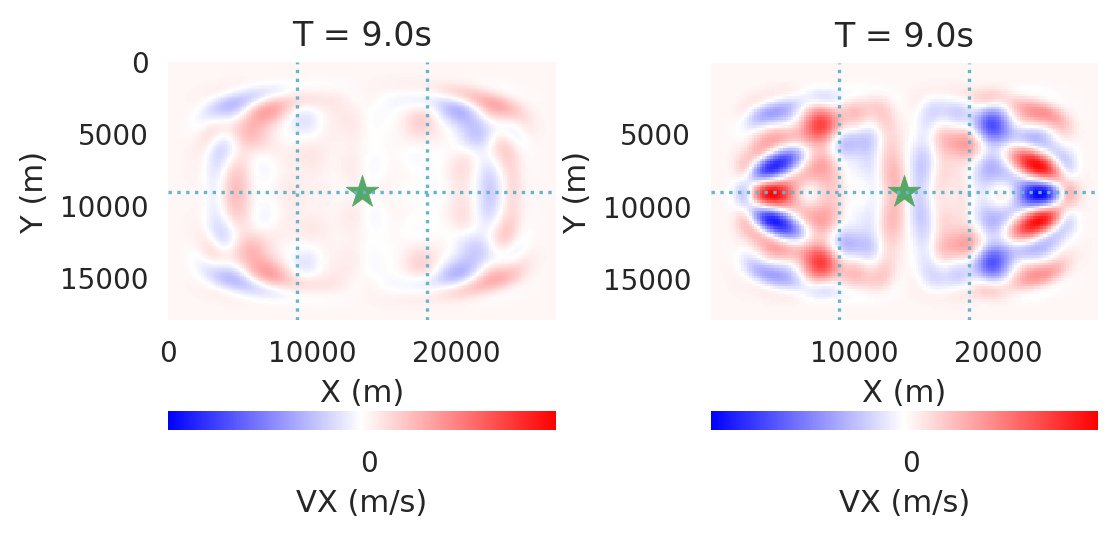

In [99]:
plot_slice_z(299, 'homo_2layer_gauss_y', comp='X')

### Source

[Text(0,0.5,'Amplitude'), (0, 4), Text(0.5,0,'Freq (Hz)')]

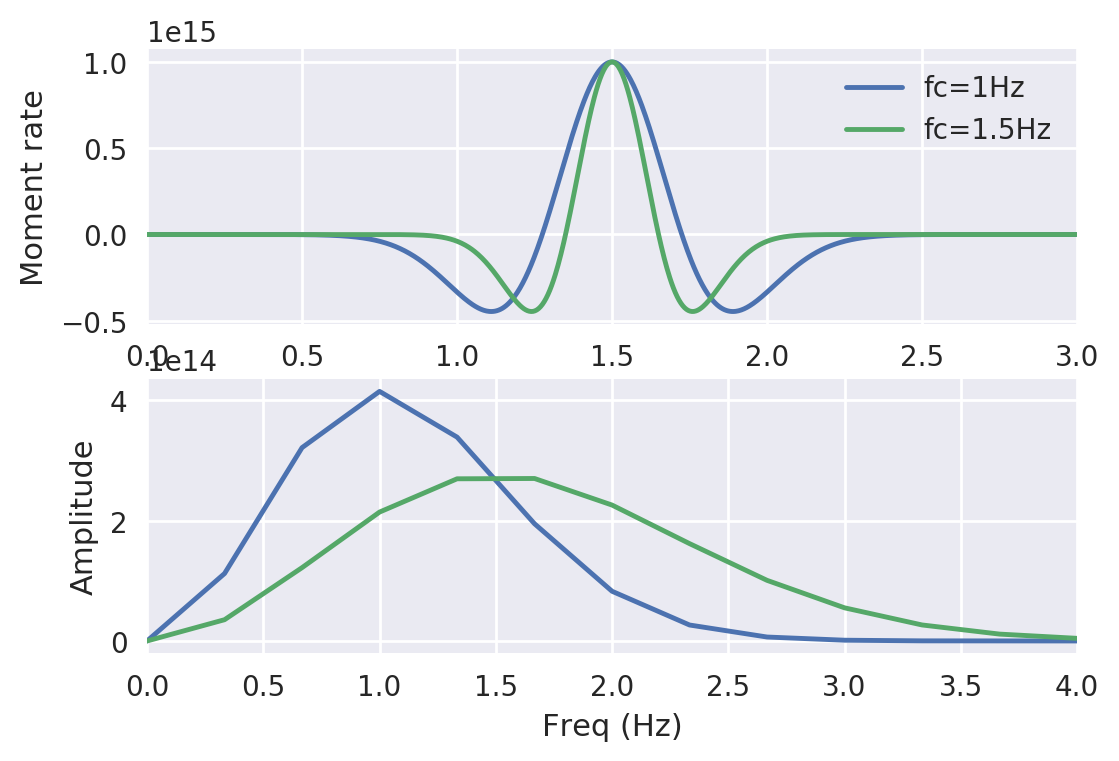

In [16]:
s = np.fromfile('homo_2layer_point_flat/source_0', dtype='float32', offset=12).reshape(-1, 6)
fft_s = np.abs(np.fft.fft(s[:, 0]) * dt)
s2 = np.fromfile('homo_2layer_toy/source_0', dtype='float32', offset=12).reshape(-1, 6)
fft_s2 = np.abs(np.fft.fft(s2[:, 0]) * dt)
f = np.arange(nt) * (1 / nt / dt)
fig, ax = plt.subplots(2, 1, dpi=200)
ax[0].plot(np.arange(nt) * dt, s[:, 0], label='fc=1Hz')
ax[0].plot(np.arange(nt) * dt, s2[:, 1], label='fc=1.5Hz')
ax[0].set(xlabel='Time (s)', ylabel='Moment rate', xlim=(0, 3))
ax[0].legend()
ax[1].plot(f, fft_s)
ax[1].plot(f, fft_s2)
ax[1].set(xlabel='Freq (Hz)', ylabel='Amplitude', xlim=(0, 4))


homo_2layer_point 0.03 10 300 1
homo_2layer_point/output_sfc/SX_0_0003000
homo_2layer_point/output_sfc/SY_0_0003000
homo_2layer_point/output_sfc/SZ_0_0003000


[Text(0,0.5,'V (m/s)'), Text(0.5,0,'Time (s)')]

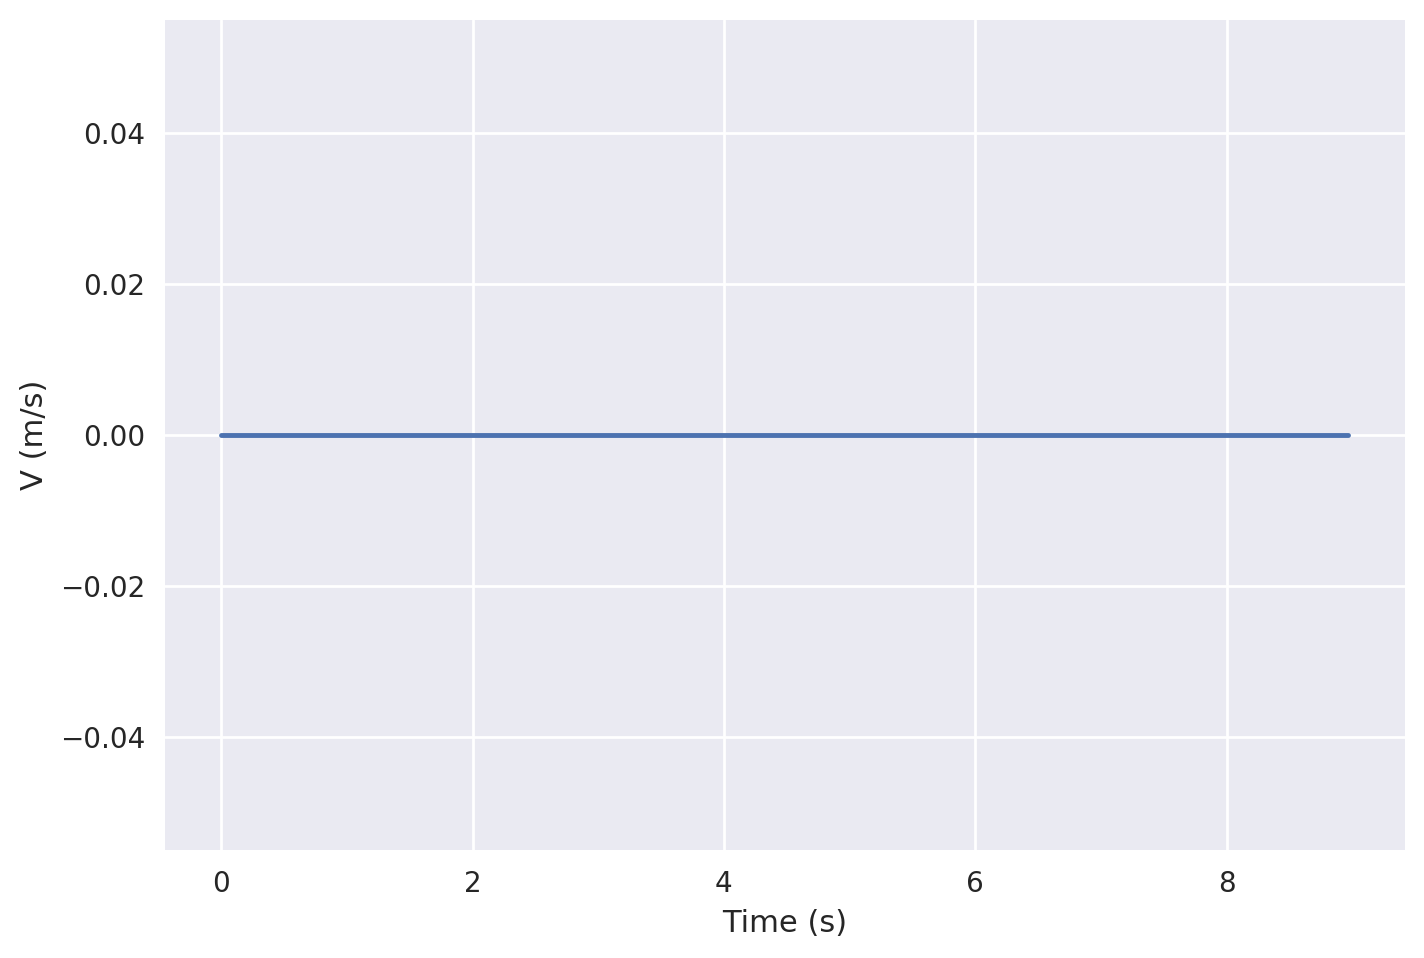

In [202]:
ix, iy = 200, 200
vel = read_syn(ix, iy, mx, my, model='homo_2layer_point')
fig, ax = plt.subplots(dpi=200)
ax.plot(np.arange(len(vel['X'])) * vel['dt'], vel['X'])
ax.set(xlabel='Time (s)', ylabel='V (m/s)')